In [ ]:
%matplotlib inline

# Lesson 6: pets revisited

In [ ]:
from fastai2.vision.all import *
from nbdev.showdoc import *

In [ ]:
bs = 64

In [ ]:
path = untar_data(URLs.PETS)

## Data augmentation

In [ ]:
tfms = partial(aug_transforms, max_rotate=20, max_zoom=1.3, max_lighting=0.4, max_warp=0.4,
                      p_affine=1., p_lighting=1.)

In [ ]:
doc(aug_transforms)

In [ ]:
def repeat_one(source, n=128): return [get_image_files(source)[0]]*n

In [ ]:
pets = DataBlock(blocks=(ImageBlock, CategoryBlock),
                 get_items=repeat_one,
                 splitter=RandomSplitter(0.2, seed=2),
                 get_y=RegexLabeller(r'([^/]+)_\d+.jpg$'))

In [ ]:
def get_dbunch(size, bs, pad_mode='reflection', batch=False):
    return pets.databunch(path/'images', path=path, item_tfms=Resize(460), bs=bs,
                          batch_tfms=[*tfms(size=size, pad_mode=pad_mode, batch=batch), Normalize.from_stats(*imagenet_stats)])

In [ ]:
dbunch = get_dbunch(224, bs, 'zeros')

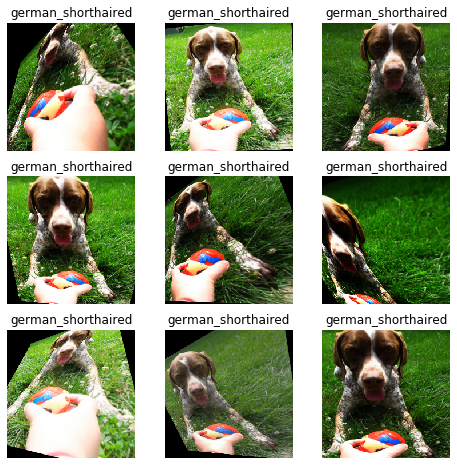

In [ ]:
dbunch.show_batch(max_n=9, figsize=(8,8))

In [ ]:
dbunch = get_dbunch(224,bs)

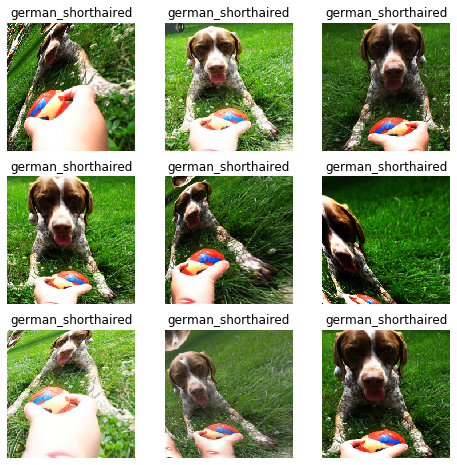

In [ ]:
dbunch.show_batch(max_n=9, figsize=(8,8))

`batch=True` means we pick the same random augmentation for all the images in the batch.

In [ ]:
dbunch = get_dbunch(224,bs,batch=True)

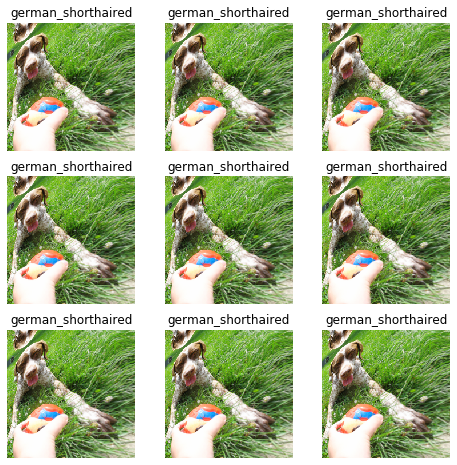

In [ ]:
dbunch.show_batch(max_n=9, figsize=(8,8))

## Train a model

In [ ]:
pets = DataBlock(blocks=(ImageBlock, CategoryBlock),
                 get_items=get_image_files,
                 splitter=RandomSplitter(0.2, seed=2),
                 get_y=RegexLabeller(r'([^/]+)_\d+.jpg$'))

In [ ]:
def get_dbunch(size, bs, pad_mode='reflection'):
    return pets.databunch(path/'images', path=path, item_tfms=RandomResizedCrop(460, min_scale=0.75), bs=bs,
                          batch_tfms=[*tfms(size=size, pad_mode=pad_mode), Normalize.from_stats(*imagenet_stats)])

In [ ]:
dbunch = get_dbunch(224,bs)

In [ ]:
learn = cnn_learner(dbunch, resnet34, metrics=error_rate, config=cnn_config(bn_final=True))

In [ ]:
learn.fit_one_cycle(3, slice(1e-2), pct_start=0.8)

epoch,train_loss,valid_loss,error_rate,time
0,1.680457,0.346096,0.080514,00:20
1,0.994624,0.260845,0.071719,00:15
2,0.730085,0.237081,0.069012,00:15


In [ ]:
learn.unfreeze()
learn.fit_one_cycle(2, lr_max=slice(1e-6,1e-3), pct_start=0.8)

epoch,train_loss,valid_loss,error_rate,time
0,0.596662,0.227051,0.058863,00:19
1,0.575870,0.229266,0.059540,00:18


In [ ]:
dbunch = get_dbunch(352,bs)
learn.dbunch = dbunch

In [ ]:
learn.fit_one_cycle(2, lr_max=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.513675,0.213754,0.051421,00:35
1,0.452948,0.209984,0.051421,00:34


In [ ]:
learn.save('352')

## Convolution kernel

In [ ]:
dbunch = get_dbunch(352,16)

In [ ]:
learn = cnn_learner(dbunch, resnet34, metrics=error_rate, config=cnn_config(bn_final=True)).load('352')

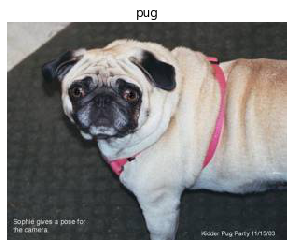

In [ ]:
idx=0
x,y = dbunch.valid_ds[idx]
show_at(dbunch.valid_ds, idx);

In [ ]:
k = tensor([
    [0.  ,-5/3,1],
    [-5/3,-5/3,1],
    [1.  ,1   ,1],
]).expand(1,3,3,3)/6

In [ ]:
k

tensor([[[[ 0.0000, -0.2778,  0.1667],
          [-0.2778, -0.2778,  0.1667],
          [ 0.1667,  0.1667,  0.1667]],

         [[ 0.0000, -0.2778,  0.1667],
          [-0.2778, -0.2778,  0.1667],
          [ 0.1667,  0.1667,  0.1667]],

         [[ 0.0000, -0.2778,  0.1667],
          [-0.2778, -0.2778,  0.1667],
          [ 0.1667,  0.1667,  0.1667]]]])

In [ ]:
k.shape

torch.Size([1, 3, 3, 3])

In [ ]:
t = tensor(x).permute(2,0,1).float(); t.shape

torch.Size([3, 233, 300])

In [ ]:
t[None].shape

torch.Size([1, 3, 233, 300])

In [ ]:
edge = F.conv2d(t[None], k)

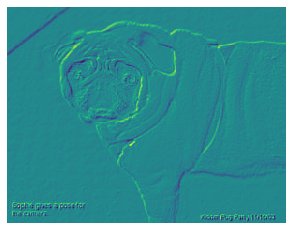

In [ ]:
show_image(edge[0], figsize=(5,5));

In [ ]:
dbunch.c

37

In [ ]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [ ]:
print(learn.summary())

Sequential (Input shape: 16 x 3 x 352 x 352)
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               16 x 64 x 176 x 176  9,408      False     
________________________________________________________________
BatchNorm2d          16 x 64 x 176 x 176  128        True      
________________________________________________________________
ReLU                 16 x 64 x 176 x 176  0          False     
________________________________________________________________
MaxPool2d            16 x 64 x 88 x 88    0          False     
________________________________________________________________
Conv2d               16 x 64 x 88 x 88    36,864     False     
________________________________________________________________
BatchNorm2d          16 x 64 x 88 x 88    128        True      
________________________________________________________________
ReLU                 16 x 64 x 88 x 88    0          False     
_____________________________________________________

## Heatmap

In [ ]:
m = learn.model.eval();

In [ ]:
b = dbunch.one_batch()
xb_im = TensorImage(dbunch.train_dl.decode(b)[0][0])
xb = b[0]

In [ ]:
def hooked_backward(cat=y):
    with hook_output(m[0]) as hook_a: 
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(xb)
            preds[0,int(cat)].backward()
    return hook_a,hook_g

In [ ]:
hook_a,hook_g = hooked_backward()

In [ ]:
acts  = hook_a.stored[0].cpu()
acts.shape

torch.Size([512, 11, 11])

In [ ]:
avg_acts = acts.mean(0)
avg_acts.shape

torch.Size([11, 11])

In [ ]:
def show_heatmap(hm):
    _,ax = plt.subplots()
    xb_im.show(ctx=ax)
    ax.imshow(hm, alpha=0.6, extent=(0,352,352,0),
              interpolation='bilinear', cmap='magma');

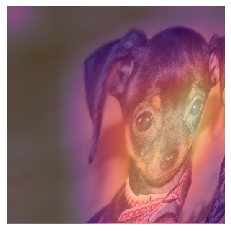

In [ ]:
show_heatmap(avg_acts)

## Grad-CAM

Paper: [Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization](https://arxiv.org/abs/1610.02391)

In [ ]:
grad = hook_g.stored[0][0].cpu()
grad_chan = grad.mean(1).mean(1)
grad.shape,grad_chan.shape

(torch.Size([512, 11, 11]), torch.Size([512]))

In [ ]:
mult = (acts*grad_chan[...,None,None]).mean(0)

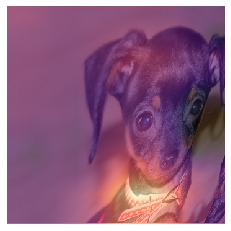

In [ ]:
show_heatmap(mult)

In [ ]:
fn = Path.home()/'tmp/bulldog_maine.png' #Replace with your own image

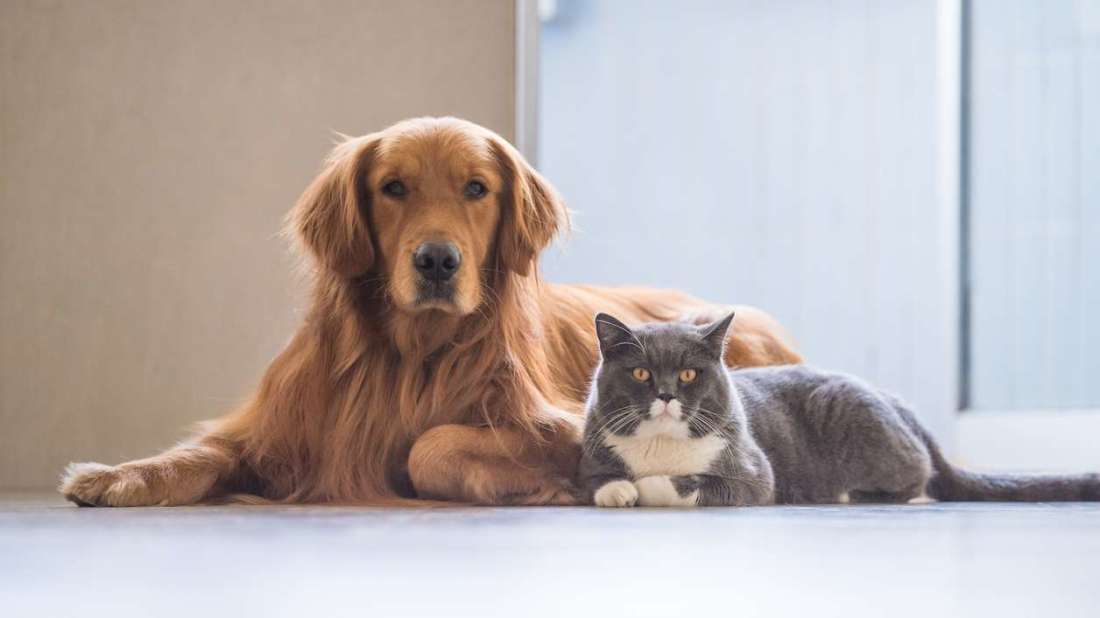

In [ ]:
x = PILImage.create(fn); x

In [ ]:
dl = test_dl(dbunch, [fn])
b = dl.one_batch()
xb_im = TensorImage(dbunch.train_dl.decode(b)[0][0])
xb = b[0]

In [ ]:
hook_a,hook_g = hooked_backward()

In [ ]:
acts = hook_a.stored[0].cpu()
grad = hook_g.stored[0][0].cpu()

grad_chan = grad.mean(1).mean(1)
mult = (acts*grad_chan[...,None,None]).mean(0)

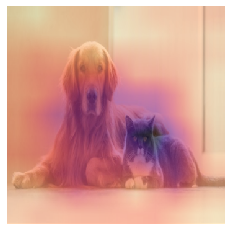

In [ ]:
show_heatmap(mult)

In [ ]:
dbunch.vocab[0]

'Abyssinian'

In [ ]:
hook_a,hook_g = hooked_backward(0)

In [ ]:
acts = hook_a.stored[0].cpu()
grad = hook_g.stored[0][0].cpu()

grad_chan = grad.mean(1).mean(1)
mult = (acts*grad_chan[...,None,None]).mean(0)

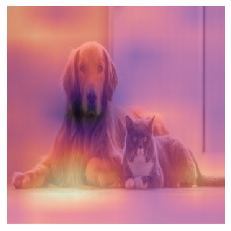

In [ ]:
show_heatmap(mult)

## fin